In [1]:
import numpy as np
import polars as pl
import os
from pathlib import Path
from typing import List, Tuple, Union
from datetime import datetime, timedelta
from pydantic import BaseModel
from loguru import logger
from enum import Enum
import random


class EndStatus(Enum):
    DISSIPATED = 0
    MOVE_OUT_OF_RESPONSIBILITY = 1
    MERGED = 2
    NEARLY_STATIONARY = 3


class CycloneCategory(Enum):
    BELOW_TD_OR_UNKNOWN = 0
    TROPICAL_DEPRESSION = 1  # 热带低压 (TD, 10.8-17.1m/s)
    TROPICAL_STORM = 2  # 热带风暴 (TS, 17.2-24.4 m/s)
    SEVERE_TROPICAL_STORM = 3  # 强热带风暴 (STS, 24.5-32.6 m/s)
    TYPHOON = 4  # 台风 (TY, 32.7-41.4 m/s)
    SEVERE_TYPHOON = 5  # 强台风 (STY, 41.5-50.9 m/s)
    SUPER_TYPHOON = 6  # 超强台风 (SuperTY, ≥51.0 m/s)
    EXTRATROPICAL = 9  # 变性 (The change is complete)


class HurricaneHeader(BaseModel):
    data_type: int
    country_code: int
    data_count: int
    hurricane_code: int
    china_hurricane_code: int
    end_status: EndStatus
    time_interval_hr: int
    hurricane_name: str
    dataset_record_time: datetime


class HurricaneEntry(BaseModel):
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


class Hurricane(BaseModel):
    header: HurricaneHeader
    entries: List[HurricaneEntry]


script_folder = Path(os.getcwd())
dataset_folder = script_folder / "CMABSTdata"

# https://tcdata.typhoon.org.cn/zjljsjj.html
# example_file = dataset_folder / "CH2022BST.txt"
example_file = dataset_folder / "CH1950BST.txt"
logger.info(f"example_file: {example_file}")


def parse_header(line: str) -> HurricaneHeader:
    entry = line.split()
    data_type = int(entry[0])
    country_code = int(entry[1])
    data_count = int(entry[2])
    hurricane_code = int(entry[3])
    try:
        china_hurricane_code = int(entry[4])
    except ValueError:
        # might be a tuple (a,b)
        codes = entry[4].split(",")
        china_hurricane_code = int(codes[0])
    hurricane_end_enum = int(entry[5])
    end_status = EndStatus(hurricane_end_enum)
    time_interval_hr = int(entry[6])
    hurricane_name = entry[7]
    dataset_record_time = entry[8]
    time_format = "%Y%m%d"
    dataset_record_time = datetime.strptime(dataset_record_time, time_format)
    return HurricaneHeader(data_type=data_type,
                           country_code=country_code,
                           data_count=data_count,
                           hurricane_code=hurricane_code,
                           china_hurricane_code=china_hurricane_code,
                           end_status=end_status,
                           time_interval_hr=time_interval_hr,
                           hurricane_name=hurricane_name,
                           dataset_record_time=dataset_record_time)


def parse_entry(line: str) -> HurricaneEntry:
    entry = line.split()
    date_str = entry[0]
    time_format = "%Y%m%d%H"
    date = datetime.strptime(date_str, time_format)
    category = int(entry[1])
    hurricane_category = CycloneCategory(category)
    latitude = float(int(entry[2])) / 10.0
    longitude = float(int(entry[3])) / 10.0
    # in hPa
    lowest_pressure = int(entry[4])
    # 2分钟平均近中心最大风速(MSW, m/s)
    # WND=9 表示 MSW < 10m/s,
    # WND=0 为缺测
    wind_speed = int(entry[5])
    # not sure about OWD
    return HurricaneEntry(date=date,
                          category=hurricane_category,
                          latitude=latitude,
                          longitude=longitude,
                          lowest_pressure=lowest_pressure,
                          wind_speed=wind_speed)


def parse_dataset(filename: str | Path):
    hurricanes: list[Hurricane] = []
    with open(filename, "r") as f:
        try:
            while True:
                # check if the line is empty
                l = f.readline()
                if not l:
                    break
                header = parse_header(l)
                count = header.data_count
                hurricane_entries = []
                for i in range(count):
                    entry = parse_entry(f.readline())
                    hurricane_entries.append(entry)
                hurricane = Hurricane(header=header, entries=hurricane_entries)
                hurricanes.append(hurricane)
        except ValueError as e:
            logger.error(f"ValueError: {e} for {filename}")
        except IndexError as e:
            logger.warning(f"IndexError: {e} for {filename}")
        except EOFError:
            logger.info(f"EOFError for {filename}")
    return hurricanes



2024-03-19 22:36:19.260 | INFO     | __main__:<module>:64 - example_file: c:\Users\cross\Desktop\code\hurrican\CMABSTdata\CH1950BST.txt


In [2]:
total_dataset: list[Hurricane] = []

for file in dataset_folder.glob("*.txt"):
    hurricanes = parse_dataset(file)
    total_dataset.extend(hurricanes)

logger.info(f"total_dataset: {len(total_dataset)}")

2024-03-19 22:36:21.460 | INFO     | __main__:<module>:7 - total_dataset: 2469


In [3]:
class FlatHurricaneEntry(BaseModel):
    name: str
    china_hurricane_code: int
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


def flat_hurricane_entries(
        hurricanes: list[Hurricane]) -> List[FlatHurricaneEntry]:

    def flat_one(h: Hurricane):
        name = h.header.hurricane_name
        hurricane_code = h.header.hurricane_code
        entries = h.entries
        return [
            FlatHurricaneEntry(name=name,
                               china_hurricane_code=hurricane_code,
                               date=e.date,
                               category=e.category,
                               latitude=e.latitude,
                               longitude=e.longitude,
                               lowest_pressure=e.lowest_pressure,
                               wind_speed=e.wind_speed) for e in entries
        ]

    entries = []
    for h in hurricanes:
        entries.extend(flat_one(h))
    return entries


flatten_entries = [
    e.model_dump() for e in flat_hurricane_entries(total_dataset)
]


def entry_enum_to_number(entry: dict[str, any]) -> dict[str, any]:
    entry['category'] = entry['category'].value
    return entry


flatten_entries_without_enum = [
    entry_enum_to_number(e) for e in flatten_entries
]

In [4]:
df = pl.DataFrame(flatten_entries_without_enum)

In [5]:
df.describe()

statistic,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,str,f64,str,f64,f64,f64,f64,f64
"""count""","""71705""",71705.0,"""71705""",71705.0,71705.0,71705.0,71705.0,71705.0
"""null_count""","""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.650066,"""1983-09-15 19:…",2.821588,20.902251,134.228423,986.340004,23.758218
"""std""",null,10.47291,null,2.330128,9.283707,16.616481,20.931241,15.36339
"""min""","""(nameless)""",1.0,"""1949-01-13 00:…",0.0,0.5,95.0,870.0,0.0
"""25%""",null,9.0,"""1965-09-21 06:…",1.0,14.2,121.8,980.0,15.0
"""50%""",null,17.0,"""1981-08-21 00:…",2.0,19.3,132.5,995.0,20.0
"""75%""",null,25.0,"""2001-09-03 06:…",4.0,25.8,145.0,1001.0,33.0
"""max""","""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1022.0,110.0


In [6]:
df_filtered = df.filter(df["wind_speed"] != 0)
df_filtered.describe()

statistic,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,str,f64,str,f64,f64,f64,f64,f64
"""count""","""65796""",65796.0,"""65796""",65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""","""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.502265,"""1985-09-05 05:…",2.866664,20.73495,133.459558,984.894963,25.891893
"""std""",null,10.381192,null,2.121499,8.752285,16.292624,21.13435,14.21218
"""min""","""(nameless)""",1.0,"""1949-01-15 00:…",0.0,0.5,95.0,870.0,8.0
"""25%""",null,9.0,"""1968-06-01 00:…",1.0,14.5,121.2,975.0,15.0
"""50%""",null,17.0,"""1984-10-31 00:…",2.0,19.4,131.7,992.0,20.0
"""75%""",null,25.0,"""2003-06-17 18:…",4.0,25.5,143.9,1000.0,35.0
"""max""","""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1016.0,110.0


<Axes: xlabel='longitude', ylabel='Count'>

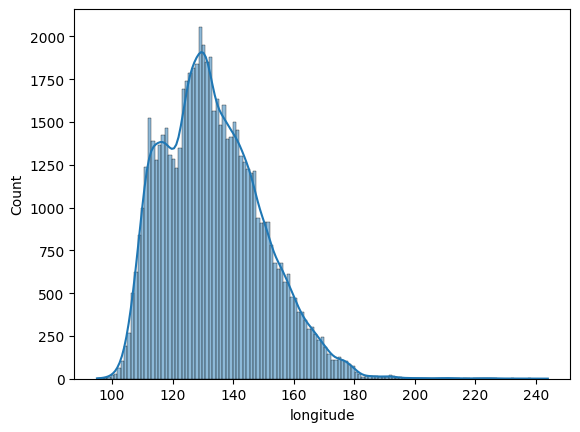

In [12]:
import seaborn as sns

sns.histplot(df_filtered.to_pandas(), x="longitude", kde=True)

In [8]:
import torch

# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"device: {device}")

2024-03-19 22:28:31.129 | INFO     | __main__:<module>:5 - device: cuda


In [19]:
import math
time = df["date"][6]
assert isinstance(time, datetime)
# use sin/cos to normalize the day in a year and the hour in a day

def sinusoidal_hour_in_day(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the hour of day from a datetime object.
    """
    # Extract the hour from the datetime object
    hour = dt.hour

    # Calculate the radians for the given hour
    radians_per_hour = 2 * math.pi / 24
    hour_in_radians = hour * radians_per_hour

    # Return the sine and cosine values
    return math.sin(hour_in_radians), math.cos(hour_in_radians)

def sinusoidal_day_in_year(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the day of year from a datetime object.
    """
    # Extract the day of year from the datetime object
    day_of_year = dt.timetuple().tm_yday

    # Handle leap years
    year_length = 366 if dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0) else 365

    # Calculate the radians for the given day of year
    radians_per_day = 2 * math.pi / year_length
    day_in_radians = day_of_year * radians_per_day

    # Return the sine and cosine values
    return math.sin(day_in_radians), math.cos(day_in_radians)

logger.info(f"{time} -> {sinusoidal_hour_in_day(time)} {sinusoidal_day_in_year(time)}")

2024-03-19 22:53:27.737 | INFO     | __main__:<module>:37 - 1949-01-14 12:00:00 -> (1.2246467991473532e-16, -1.0) (0.2386727660059501, 0.9711000518829505)


In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# longitude and latitude
scaler = MinMaxScaler()
latitude = scaler.fit_transform(df_filtered["latitude"].to_numpy().reshape(-1, 1)).reshape(-1)
longitude = scaler.fit_transform(df_filtered["longitude"].to_numpy().reshape(-1, 1)).reshape(-1)

# wind speed
scaler = StandardScaler()
wind_speed = scaler.fit_transform(df_filtered["wind_speed"].to_numpy().reshape(-1, 1)).reshape(-1)

# lowest pressure
scaler = StandardScaler()
lowest_pressure = scaler.fit_transform(df_filtered["lowest_pressure"].to_numpy().reshape(-1, 1)).reshape(-1)

In [31]:
with_normalized_time = df_filtered.with_columns([
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[0]).alias("sin_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[1]).alias("cos_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[0]).alias("sin_hour_in_day"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[1]).alias("cos_hour_in_day"),
    pl.Series("latitude_norm", latitude),
    pl.Series("longitude_norm", longitude),
    pl.Series("wind_speed_norm", wind_speed),
    pl.Series("lowest_pressure_norm", lowest_pressure),
])

df_features = with_normalized_time.select([
    "sin_day_in_year",
    "cos_day_in_year",
    "sin_hour_in_day",
    "cos_hour_in_day",
    "latitude_norm",
    "longitude_norm",
    "wind_speed_norm",
    "lowest_pressure_norm",
])

In [32]:
df_features.describe()

statistic,sin_day_in_year,cos_day_in_year,sin_hour_in_day,cos_hour_in_day,latitude_norm,longitude_norm,wind_speed_norm,lowest_pressure_norm
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.498177,-0.264362,0.006157,0.003637,0.290732,0.258291,7.5743e-17,-2.4023e-16
"""std""",0.550623,0.615432,0.705854,0.708332,0.125751,0.10942,1.000008,1.000008
"""min""",-0.999991,-1.0,-1.0,-1.0,0.0,0.0,-1.258922,-5.43645
"""25%""",-0.927542,-0.809017,0.0,-0.707107,0.201149,0.175957,-0.766383,-0.468197
"""50%""",-0.699458,-0.413279,1.2246e-16,6.1232e-17,0.271552,0.246474,-0.41457,0.336187
"""75%""",-0.263665,0.209315,1.0,1.0,0.359195,0.328408,0.640871,0.71472
"""max""",0.999991,1.0,1.0,1.0,1.0,1.0,5.918075,1.471788


In [ ]:
import numpy as np
import keras
from keras import layers
from keras import ops

# use LSTM
model = keras.Sequential([
    layers.LSTM(64, input_shape=(8, 1)),
    layers.Dense(1)
])

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1, l2

# 文件夹路径
folder_path = "D:\\毕业论文\\数据集\\insert"

# 获取文件夹中所有文件
files = os.listdir(folder_path)

X_all, y_all = [], []

for file_name in files:
    file_path = os.path.join(folder_path, file_name)
    data = np.loadtxt(file_path, delimiter=' ')
    X, y = create_dataset(data, time_steps)
    X_all.extend(X)
    y_all.extend(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

# 定义和编译 LSTM 模型
model = Sequential([
    LSTM(64, input_shape=(X_all.shape[1], X_all.shape[2]), kernel_regularizer=l2(0.01)),
    Dense(y_all.shape[1], kernel_regularizer=l2(0.01))
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_all, y_all, epochs=2, batch_size=32)

# 保存模型
model.save('lstm_model.h5')


Epoch 1/2
 335/2293 [===>..........................] - ETA: 11s - loss: nan

KeyboardInterrupt: 

In [ ]:
# 打印模型摘要
print(model.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                17920     
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
Total params: 18,245
Trainable params: 18,245
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x) # LSTM层
        out = self.fc(out[:, -1, :]) # 全连接层
        return out

ModuleNotFoundError: No module named 'torch._prims_common'